# Appendix data

In this notebook we generate some figures that will be use in the appendix of the documentation.

## Models parameters

Obtain the number of parameters in each of the trained models.

In [1]:
from pathlib import Path

from flair.models.sequence_tagger_model import SequenceTagger
from myst_nb import glue
import pandas as pd
import torch

def get_parameter_num(model_path: Path) -> int:
    """Obtain the number of parameter in a model

    Args:
        model_path (Path): Path to a SequenceTagger model

    Returns:
        int: Number of parameters of the model
    """
    model = SequenceTagger.load(model_path)
    parameters = model.parameters()
    return sum(map(torch.numel, parameters))

def make_pretty(styler):
    styler.background_gradient(axis=None, cmap="YlGnBu")
    styler.set_table_styles([
        {'selector': 'th.col_heading.level0', 'props': 'text-align: center; font-size: 1.5em;'},
        {"selector": "", "props": [("border", "1px solid grey")]},
        {"selector": "tbody td", "props": [("border", "1px solid grey")]},
        {"selector": "th", "props": [("border", "1px solid grey")]},
    ], overwrite=False)
    styler.format( "{:.0f}",)
    return styler


In [3]:
root = Path.cwd().parents[2] / "MedDocAn/experiments"

mdpths = {
    ("FINETUNE", "XLMR"): root / "corpus_sentence_xlmrl_finetune/an_wh_rs_False_dpt_0_emb_xlm-roberta-large-cased_FT_True_Ly_-1_seed_1_lr_5e-06_it_40_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.05/0/final-model.pt",
    ("FINETUNE", "XLMR + CONTEXT"): root / "corpus_sentence_xlmrl_context_finetune/an_wh_rs_False_dpt_0_emb_xlm-roberta-large-cased-context_FT_True_Ly_-1_seed_1_lr_5e-06_it_40_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1/0/final-model.pt",
    ("FINETUNE", "XLMR + WE"): root / "corpus_sentence_xlmrl_we_finetune/an_wh_rs_False_dpt_0_emb_Stack(0_es-wiki-fasttext-300d-1M, 1_1-xlm-roberta-large-cased_FT_True_Ly_-1_seed_1)_lr_5e-06_it_40_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.05/0/final-model.pt",
    ("FINETUNE", "BETO"): root / "corpus_sentence_bert_context_finetune/an_wh_rs_False_dpt_0_emb_beto-cased-context_FT_True_Ly_-1_seed_1_lr_5e-06_it_150_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1/0/final-model.pt",
    ("FINETUNE", "BETO + WE"): root / "corpus_sentence_bert_context_we_finetune_it_150/an_wh_rs_False_dpt_0_emb_Stack(0_es-wiki-fasttext-300d-1M, 1_1-beto-cased_FT_True_Ly_-1_seed_1)_lr_5e-06_it_150_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1/0/final-model.pt",
    ("LSTM CRF", "BETO"): root / "corpus_sentence_bert_context_lstm_crf/an_wh_rs_False_dpt_0_emb_beto_Ly_all_mean_context_seed_1_hdn_sz_256_lr_0.1_it_500_bs_4_opti_SGD_pjct_emb_False_rnn_ly_2_sdl_AnnealOnPlateau_use_crf_True_use_rnn_True/0/final-model.pt",
    ("LSTM CRF", "BETO + WE"): root / "corpus_sentence_bert_context_we_lstm_crf/an_wh_rs_False_dpt_0_emb_Stack(0_es-wiki-fasttext-300d-1M, 1_1-beto_Ly_all_mean_context_seed_1)_hdn_sz_256_lr_0.1_it_500_bs_4_opti_SGD_pjct_emb_False_rnn_ly_2_sdl_AnnealOnPlateau_use_crf_True_use_rnn_True/0/final-model.pt",
    ("LSTM CRF", "FLAIR"): root / "corpus_sentence_flair_lstm_crf/an_wh_rs_True_dpt_0.08716810045694838_emb_seed_1_Stack(0_lm-es-forward.pt, 1_lm-es-backward.pt)_hdn_sz_256_lr_0.1_it_150_bs_4_opti_SGD_pjct_emb_True_rnn_ly_2_sdl_AnnealOnPlateau_use_crf_True_use_rnn_True/0/final-model.pt",
    ("LSTM CRF", "FLAIR + WE"): root / "corpus_sentence_flair_we_lstm_crf/results_seed_10/final-model.pt",
}

model_parameters_num = {k: get_parameter_num(v) for k, v in mdpths.items()}

df = (pd.DataFrame(model_parameters_num, index=["Numero de parámetros en Million"], dtype=int) / 1e6)

style = df.style.pipe(make_pretty)

glue("model_parameters", style)


HfHubHTTPError: <class 'requests.exceptions.HTTPError'> (Request ID: lYHdrtQyPpSgxZoKCpLy1)

## Training time

Here we compare the training time for each architectures that we have used in the experiments.

In [4]:
from pathlib import Path
import pandas as pd
from typing import List, Callable
from datetime import timedelta
from pandas import Timestamp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

def get_training_time(pth: Path) -> Timestamp:
    """Compute the training time by reading the loss.tsv file produce by Flair
    training function. 

    Args:
        pth (Path): Path to the loss.tsv file.

    Returns:
        Timestamp: Training time.
    """
    df = pd.read_csv(pth, sep="\t")
    new: List[Timestamp] = []
    old = pd.to_datetime(df["TIMESTAMP"], unit="ns")
    days = 0
    for i, t in enumerate(old):
        if i > 0 and t.hour < new[i-1].hour:
            days += 1
        new.append(t + timedelta(hours=24*days))
    total_time = np.ptp(new)
    return total_time

def collect_training_times(seeds: List[int], get_pth: Callable[[int], str], name: str = None):
    training_time: List[Timestamp] = []
    for seed in seeds:
        pth = get_pth(seed)
        training_time.append(get_training_time(pth))
    return pd.DataFrame(training_time, columns=[name])

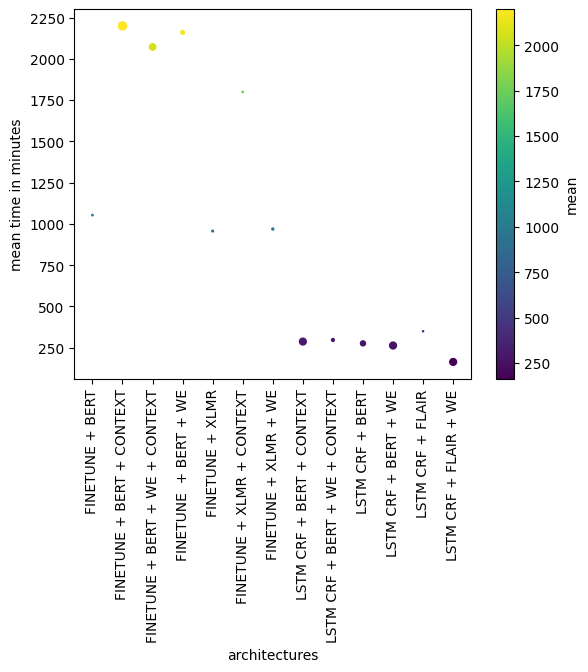

In [5]:
base = Path.cwd().parents[1] / "experiments"

collect_results = {
    "FINETUNE + BERT": {
        "seeds": [1, 12, 33],
        "get_pth": lambda seed: base / f"corpus_sentence_bert_finetune_it_150/an_wh_rs_False_dpt_0_emb_beto-cased_FT_True_Ly_-1_seed_{seed}_lr_5e-06_it_150_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1/0/loss.tsv",
    },
    "FINETUNE + BERT + CONTEXT": {
        "seeds": [1, 12, 33],
        "get_pth": lambda seed: base / f"corpus_sentence_bert_context_finetune/an_wh_rs_False_dpt_0_emb_beto-cased-context_FT_True_Ly_-1_seed_{seed}_lr_5e-06_it_150_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1/0/loss.tsv",
    },
    "FINETUNE + BERT + WE + CONTEXT": {
        "seeds": [1, 12, 33],
        "get_pth": lambda seed: base / f"corpus_sentence_bert_context_we_finetune_it_150/an_wh_rs_False_dpt_0_emb_Stack(0_es-wiki-fasttext-300d-1M, 1_1-beto-cased_FT_True_Ly_-1_seed_{seed})_lr_5e-06_it_150_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1/0/loss.tsv",
    },
    "FINETUNE  + BERT + WE": {
        "seeds": [1, 12, 33],
        "get_pth": lambda seed: base / f"corpus_sentence_bert_we_finetune_it_150/an_wh_rs_False_dpt_0_emb_Stack(0_es-wiki-fasttext-300d-1M, 1_1-beto-cased_FT_True_Ly_-1_seed_{seed})_lr_5e-06_it_150_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1/0/loss.tsv",
    },
    "FINETUNE + XLMR": {
        "seeds": [1, 12, 33],
        "get_pth": lambda seed: base / f"corpus_sentence_xlmrl_finetune/an_wh_rs_False_dpt_0_emb_xlm-roberta-large-cased_FT_True_Ly_-1_seed_{seed}_lr_5e-06_it_40_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.05/0/loss.tsv",
    },
    "FINETUNE + XLMR + CONTEXT": {
        "seeds": [1, 12, 33],
        "get_pth": lambda seed: base / f"corpus_sentence_xlmrl_context_finetune/an_wh_rs_False_dpt_0_emb_xlm-roberta-large-cased-context_FT_True_Ly_-1_seed_{seed}_lr_5e-06_it_40_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1/0/loss.tsv",
    },
    "FINETUNE + XLMR + WE": {
        "seeds": [1, 12, 33],
        "get_pth": lambda seed: base / f"corpus_sentence_xlmrl_we_finetune/an_wh_rs_False_dpt_0_emb_Stack(0_es-wiki-fasttext-300d-1M, 1_1-xlm-roberta-large-cased_FT_True_Ly_-1_seed_{seed})_lr_5e-06_it_40_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.05/0/loss.tsv",
    },
    "LSTM CRF + BERT + CONTEXT": {
        "seeds": [1, 12, 33],
        "get_pth": lambda seed: base / f"corpus_sentence_bert_context_lstm_crf/an_wh_rs_False_dpt_0_emb_beto_Ly_all_mean_context_seed_{seed}_hdn_sz_256_lr_0.1_it_500_bs_4_opti_SGD_pjct_emb_False_rnn_ly_2_sdl_AnnealOnPlateau_use_crf_True_use_rnn_True/0/loss.tsv",
    },
    "LSTM CRF + BERT + WE + CONTEXT": {
        "seeds": [1, 12, 33],
        "get_pth": lambda seed: base / f"corpus_sentence_bert_context_we_lstm_crf/an_wh_rs_False_dpt_0_emb_Stack(0_es-wiki-fasttext-300d-1M, 1_1-beto_Ly_all_mean_context_seed_{seed})_hdn_sz_256_lr_0.1_it_500_bs_4_opti_SGD_pjct_emb_False_rnn_ly_2_sdl_AnnealOnPlateau_use_crf_True_use_rnn_True/0/loss.tsv",
    },
    "LSTM CRF + BERT": {
        "seeds": [1, 12, 33],
        "get_pth": lambda seed: base / f"corpus_sentence_bert_lstm_crf/an_wh_rs_False_dpt_0_emb_beto_Ly_all_mean_seed_{seed}_hdn_sz_256_lr_0.1_it_500_bs_4_opti_SGD_pjct_emb_False_rnn_ly_2_sdl_AnnealOnPlateau_use_crf_True_use_rnn_True/0/loss.tsv",
    },
    "LSTM CRF + BERT + WE": {
        "seeds": [1, 12, 33],
        "get_pth": lambda seed: base / f"corpus_sentence_bert_we_lstm_crf/an_wh_rs_False_dpt_0_emb_Stack(0_es-wiki-fasttext-300d-1M, 1_1-beto_Ly_all_mean_seed_{seed})_hdn_sz_256_lr_0.1_it_500_bs_4_opti_SGD_pjct_emb_False_rnn_ly_2_sdl_AnnealOnPlateau_use_crf_True_use_rnn_True/0/loss.tsv",
    },
    "LSTM CRF + FLAIR": {
        "seeds": [1, 12, 33],
        "get_pth": lambda seed: base / f"corpus_sentence_flair_lstm_crf/an_wh_rs_True_dpt_0.08716810045694838_emb_seed_{seed}_Stack(0_lm-es-forward.pt, 1_lm-es-backward.pt)_hdn_sz_256_lr_0.1_it_150_bs_4_opti_SGD_pjct_emb_True_rnn_ly_2_sdl_AnnealOnPlateau_use_crf_True_use_rnn_True/0/loss.tsv",
    },
    "LSTM CRF + FLAIR + WE": {
        "seeds": [1, 10, 42],
        "get_pth": lambda seed: base / f"corpus_sentence_flair_we_lstm_crf/results_seed_{seed}/loss.tsv",
    },
}
for k, v in collect_results.items():
    collect_results[k]["timestamp"] = collect_training_times(v["seeds"], v["get_pth"], k)

training_times = pd.concat([collect_results[k]["timestamp"] for k in collect_results], axis=1)


# plot
df = training_times.astype('timedelta64[m]').describe().T.reset_index()
ax: Axes = (
    df.plot.scatter(
        "index",
        "mean",
        # yerr="std",
        use_index=True,
        rot="vertical",
        ylabel="mean time in minutes",
        xlabel="architectures",
        c="mean",
        s="std",
        colormap='viridis',
    )
)
glue("training_time", ax.get_figure(), display=False)
